In [1]:
import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
from IPython.display import Image
import tensorflow as tf

2024-09-14 09:18:27.562271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 09:18:27.562298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 09:18:27.563385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 09:18:27.569475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 09:18:30.454610: W tensorflow/compiler/tf2

In [2]:
from omnifold import DataLoader, MultiFold, PET, SetStyle, HistRoutine

Horovod instalation found.


# OmniFold example using point clouds as inputs

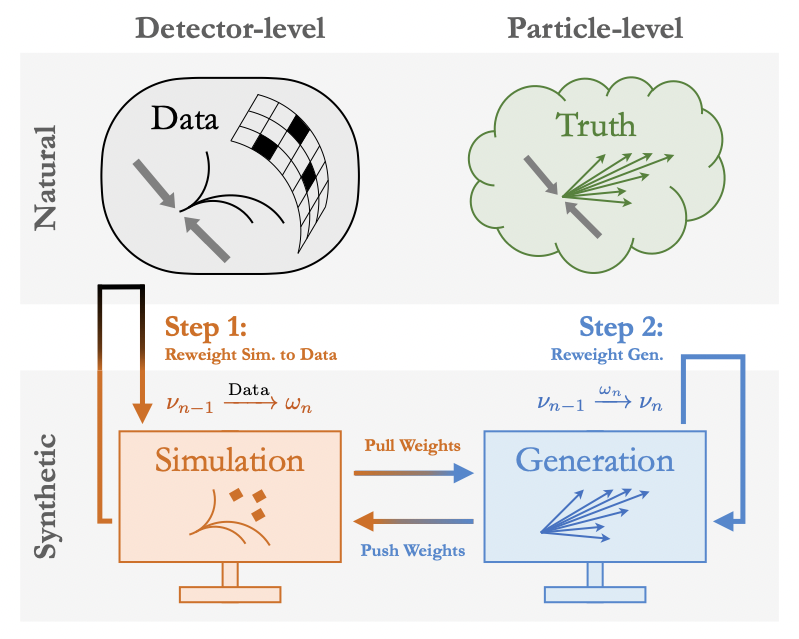

In [3]:
Image(filename='Omnifold.png')

In [4]:
def detector(x,std = 0.5):
    """ Create a fake detector response that smears the inputs given a gaussian distribution with mean 0 and std"""
    return x + np.random.normal(size=x.shape)*std

In [5]:
nevts = 1_000_00 #Number of training events we are going to use
ndim = 4 #Number of features we are going to create
npart = 3

In [6]:
gen_data = np.random.normal(size=(nevts,npart,ndim),loc=ndim*[0.0],scale=ndim*[1.0])
reco_data = detector(gen_data)
gen_mc = np.random.normal(size=(nevts,npart,ndim),loc=ndim*[1.0],scale=ndim*[1.0])
reco_mc = detector(gen_mc)

data = DataLoader(reco = reco_data,normalize=True)
mc = DataLoader(reco = reco_mc,gen = gen_mc,normalize=True)

INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000 ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 1000000 ...


## Let's take a quick look at the data

(<Figure size 900x900 with 2 Axes>,
 <Axes: ylabel='Normalized number of events'>)

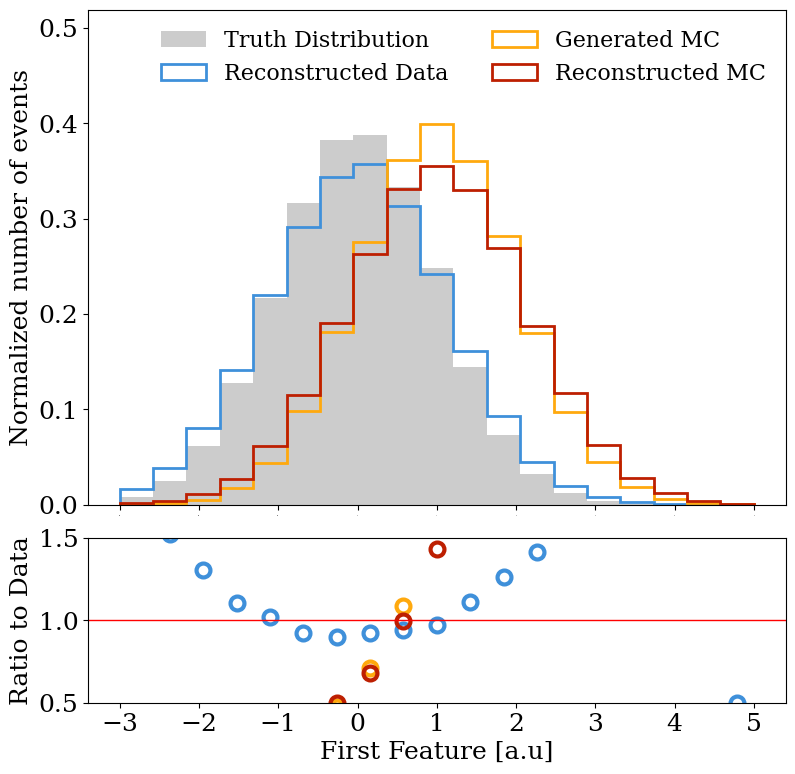

In [7]:
SetStyle()
data_dict = {
    'Truth Distribution': gen_data[:,0, 0],
    'Reconstructed Data': reco_data[:,0, 0],
    'Generated MC': gen_mc[:,0, 0],
    'Reconstructed MC': reco_mc[:,0, 0],
}
HistRoutine(data_dict,'First Feature [a.u]', reference_name = 'Truth Distribution', binning = np.linspace(-3,5,20))

## Let's now create the neural network models we are going to use to model the weight distributions

In [8]:
model1 = PET(ndim,num_part=npart, num_heads = 1, num_transformer = 1, local = False, projection_dim = 64)
model2 = PET(ndim,num_part=npart, num_heads = 1, num_transformer = 1, local = False, projection_dim = 64)

2024-09-14 09:18:39.098699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38384 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-09-14 09:18:39.100460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38384 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-09-14 09:18:39.102182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38384 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2024-09-14 09:18:39.106623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38384 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [9]:
model1.build(input_shape = (1,npart,ndim))
print(model1.summary())

Model: "pet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1)                 110145    
                                                                 
Total params: 110147 (430.26 KB)
Trainable params: 110145 (430.25 KB)
Non-trainable params: 2 (8.00 Byte)
_________________________________________________________________
None


## Let's now unfold!

In [10]:
omnifold = MultiFold(
    "Gaussian_Point_Cloud_test",
    model1,
    model2,
    data,
    mc,
    batch_size = 512,
    niter = 4,  #Number of Iterations                     
    epochs=100,     
    weights_folder = 'weights',
    verbose = True,
    lr = 5e-5,
)

In [ ]:
omnifold.Unfold()

390 training steps at reco and 390 steps at gen
ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 199680, Test events used: 39935
################################################################################
Epoch 1/100


2024-09-14 09:18:49.184799: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fde69b94fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-14 09:18:49.184815: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-14 09:18:49.184818: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-14 09:18:49.184821: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-14 09:18:49.184824: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-14 09:18:49.190817: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-14 09:1

312/312 [==============================] - 18s 16ms/step - loss: 2.5971 - val_loss: 1.6029 - lr: 5.0000e-05
Epoch 2/100
312/312 [==============================] - 4s 14ms/step - loss: 1.5542 - val_loss: 1.5522 - lr: 5.0000e-05
Epoch 3/100
312/312 [==============================] - 4s 13ms/step - loss: 1.5340 - val_loss: 1.5417 - lr: 5.0000e-05
Epoch 4/100
312/312 [==============================] - 4s 13ms/step - loss: 1.5247 - val_loss: 1.5365 - lr: 5.0000e-05
Epoch 5/100
312/312 [==============================] - 4s 14ms/step - loss: 1.5232 - val_loss: 1.5365 - lr: 5.0000e-05
Epoch 6/100
312/312 [==============================] - 4s 14ms/step - loss: 1.5192 - val_loss: 1.5349 - lr: 5.0000e-05
Epoch 7/100
312/312 [==============================] - 4s 13ms/step - loss: 1.5213 - val_loss: 1.5337 - lr: 5.0000e-05
Epoch 8/100
312/312 [==============================] - 4s 13ms/step - loss: 1.5193 - val_loss: 1.5410 - lr: 5.0000e-05
Epoch 9/100
312/312 [==============================] - 4s 1

## Now, let's evaluate the model!

In [ ]:
validation_data = np.random.normal(size=(5*nevts,npart,ndim),loc=ndim*[1.0],scale=ndim*[1.0])
unfolded_weights  = omnifold.reweight(validation_data,omnifold.model2,batch_size=1000)   

In [ ]:
print(unfolded_weights)

## More plots!

In [ ]:
data_dict = {
    'Truth Distribution': gen_data[:,0,0],
    'Reconstructed Data': reco_data[:,0,0],
    'Generated MC': gen_mc[:,0,0],
    'Reconstructed MC': reco_mc[:,0,0],
    'Unfolded Data': validation_data[:,0,0],
}

weight_dict = {
    'Truth Distribution': data.weight,
    'Reconstructed Data': data.weight,
    'Generated MC': mc.weight,
    'Reconstructed MC': mc.weight,
    'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,'First Feature [a.u]',
                    reference_name = 'Truth Distribution',
                    weights = weight_dict,
                    binning = np.linspace(-3,5,20)
                    )
